### Initialize Unity communication

In [127]:
import json
import IPython.display
import PIL
import os
from graph_export.scriptcheck import UnityCommunication
comm = UnityCommunication()

In [2]:
comm.reset()

True

# Scene start

In [56]:
_, ncameras = comm.camera_count()
print('There are {} cameras'.format(ncameras))
cameras_select = list(range(ncameras))
ids = [-9, -6, -5]
cameras_select = [cameras_select[x] for x in ids]

There are 81 cameras


## Display the scene

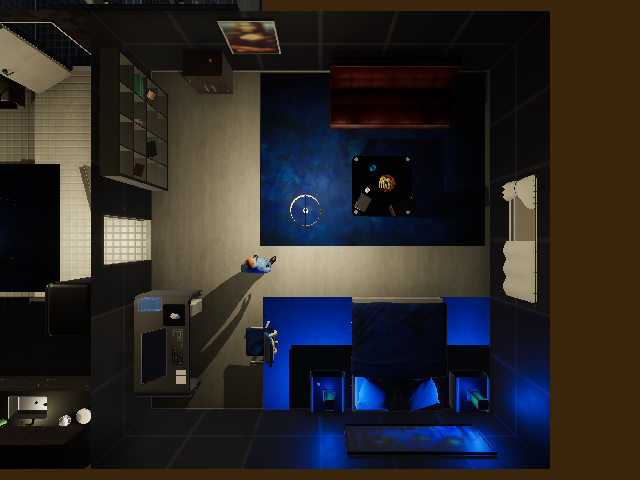

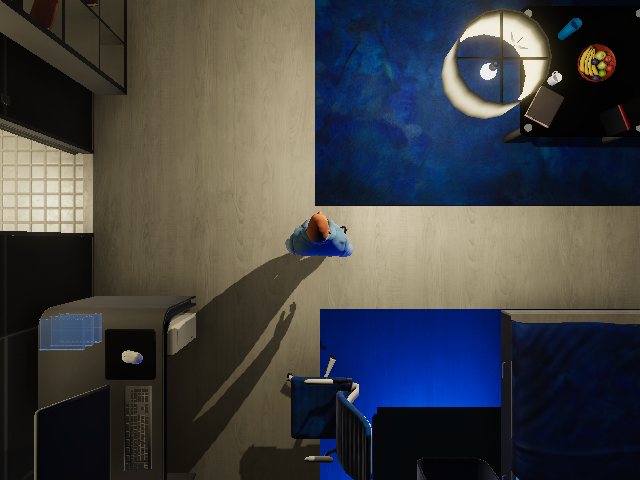

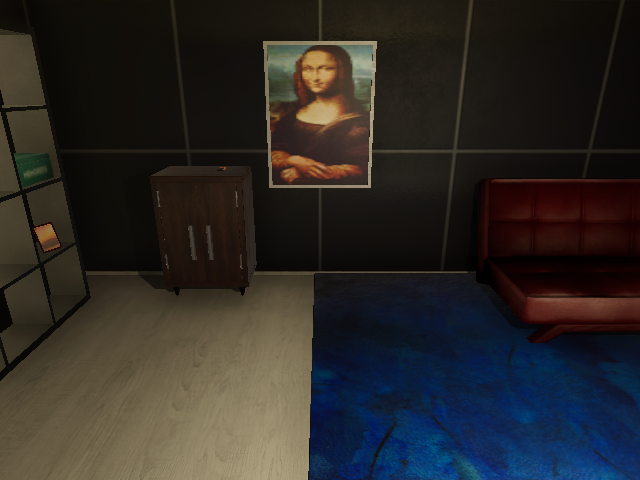

In [59]:
(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal')
for img in imgs:
    IPython.display.display(PIL.Image.fromarray(img[:,:,::-1]))

## Switch to new scene

In [71]:
# Rooms 0 to 6
comm.reset(4)

True

There are 79 cameras


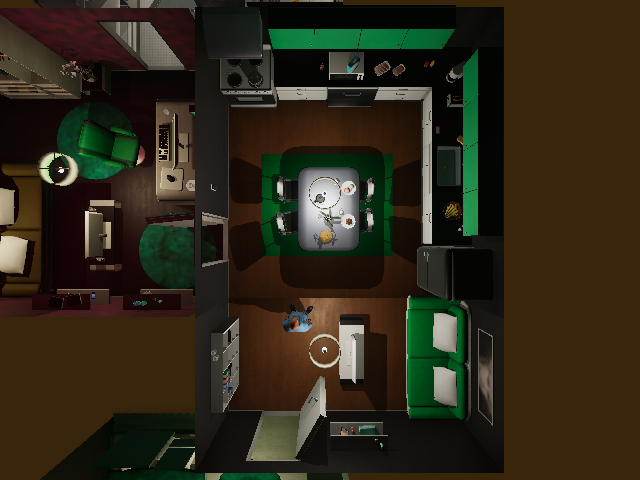

In [72]:
_, ncameras = comm.camera_count()
print('There are {} cameras'.format(ncameras))
cameras_select = list(range(ncameras))
ids = [-10]
cameras_select = [cameras_select[x] for x in ids]
(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal')
for img in imgs:
    IPython.display.display(PIL.Image.fromarray(img[:,:,::-1]))

# Obtain the current graph

In [25]:
success, graph = comm.environment_graph()

True

In [26]:
print('Example node')
print(graph['nodes'][0])
print('')
print('Example edge')
print(graph['edges'][0])

Example node
{'id': 1, 'category': 'Rooms', 'class_name': 'bathroom', 'prefab_name': 'PRE_ROO_Bathroom_05', 'bounding_box': {'center': [-2.53400326, 1.24232924, 8.51808], 'size': [5.00001144, 2.51735854, 5.4638443]}, 'properties': [], 'states': []}

Example edge
{'from_id': 2, 'to_id': 1, 'relation_type': 'INSIDE'}


In [40]:
character_node = [x for x in graph['nodes'] if x['class_name'] == 'character'][0]
character_id = character_node['id']
edges_character = [x for x in graph['edges'] if x['from_id'] == character_id]
print('Relations with character')
for edge in edges_character:
    node = find_nodes(graph, id=edge['to_id'])[0]
    print('  {} {} ({})'.format(edge['relation_type'], node['class_name'], node['id']))
    

Relations with character
  INSIDE bedroom (161)
  FACING wallpictureframe (200)
  FACING wallpictureframe (201)
  FACING computer (208)
  CLOSE floor (167)
  CLOSE floor (168)
  CLOSE chair (193)
  CLOSE mouse (212)
  CLOSE mousemat (213)
  CLOSE ceilinglamp (236)
  CLOSE computer (208)
  CLOSE papertray (233)
  CLOSE ceiling (184)
  CLOSE ceiling (181)
  CLOSE wall (174)
  CLOSE floor (164)
  CLOSE floor (163)
  CLOSE floor (162)
  CLOSE desk (192)
  CLOSE rug (202)


#### Define some functions for manipulating the environment graph

In [3]:
def find_nodes(graph, **kwargs):
    if len(kwargs) == 0:
        return None
    else:
        k, v = next(iter(kwargs.items()))
        return [n for n in graph['nodes'] if n[k] == v]
    
def find_edges_from(graph, id):
    nb_list = [(e['relation_type'], e['to_id']) for e in graph['edges'] if e['from_id'] == id]
    return [(rel, find_nodes(graph, id=n_id)[0]) for (rel, n_id) in nb_list]

def clean_graph(graph):
    """
    Remove bounds to reflect real input by Andrew & Xavier
    """
    new_nodes = []
    for n in graph['nodes']:
        nc = dict(n)
        if 'bounding_box' in nc:
            del nc['bounding_box']
        new_nodes.append(nc)
    return {'nodes': new_nodes, 'edges': list(graph['edges'])}
    

def remove_edges(graph, n, fr=True, to=True):
    n_id = n['id']
    new_edges = [e for e in graph['edges'] if 
                 (e['from_id'] != n_id or not fr) and (e['to_id'] != n_id or not to)]
    graph['edges'] = new_edges

def remove_edge(graph, fr_id, rel, to_id):
    new_edges = [e for e in graph['edges'] if 
                 not (e['from_id'] == fr_id and e['to_id'] == to_id and e['relation_type'] == rel)]
    graph['edges'] = new_edges
    
def add_node(graph, n):
    graph['nodes'].append(n)

def add_edge(graph, fr_id, rel, to_id):
    graph['edges'].append({'from_id': fr_id, 'relation_type': rel, 'to_id': to_id})
    
def clean_graph(graph):
    """
    Remove bounds to reflect real input by Andrew & Xavier
    """
    new_nodes = []
    for n in graph['nodes']:
        nc = dict(n)
        if 'bounding_box' in nc:
            del nc['bounding_box']
        new_nodes.append(nc)
    return {'nodes': new_nodes, 'edges': list(graph['edges'])}



In [76]:
def add_cat(graph):
    graph_1 = clean_graph(graph)
    sofa = find_nodes(graph_1, class_name='sofa')[-2]
    add_node(graph_1, {'class_name': 'cat', 'category': 'Animals', 'id': 1000, 'properties': [], 'states': []})
    add_edge(graph_1, 1000, 'ON', sofa['id'])
    return graph_1

## Add object and view

In [77]:
comm.reset()
success, graph = comm.environment_graph()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)

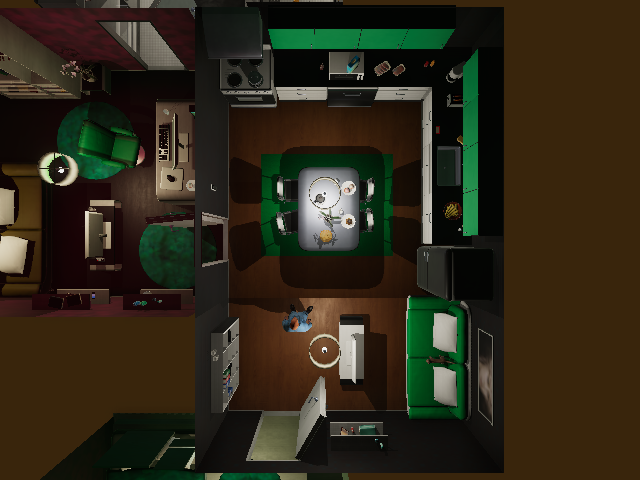

In [78]:
_, ncameras = comm.camera_count()
cameras_select = list(range(ncameras))
cameras_select = [cameras_select[-10]]
(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal')
IPython.display.display(PIL.Image.fromarray(imgs[-1][:,:,::-1]))

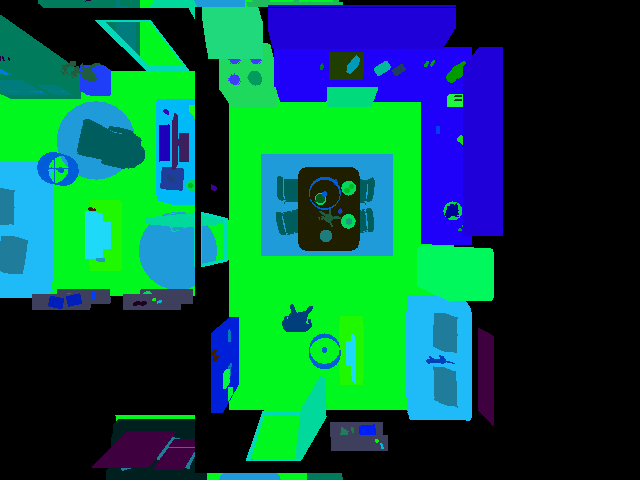

In [79]:
(ok_img, imgs) = comm.camera_image(cameras_select, mode='seg_class')
IPython.display.display(PIL.Image.fromarray(imgs[-1][:,:,::-1]))

# Generating Scripts

In [103]:
script = ['[Walk] <cat> (1)', '[Grab] <cat> (1)']
success, message = comm.render_script(script=script, 
                                      capture_screenshot=True, 
                                      find_solution=False, 
                                      camera_mode='FIRST_PERSON')

Available Actions:
- Open
- Close
- SwitchOn
- SwitchOff
- PutBack
- PutIn
- Drink
- Talk
- Text
- Grab
- Sit
- StandUp
- Walk
- Run
- TurnTo
- PointAt
- LookAt
- Find
- Touch

Paramters to render_script are:
- script: a list of script lines
- randomize_execution: randomly choose elements
- random_seed: random seed to use when randomizing execution, -1 means that the seed is not set
- find_solution: find solution (True) or use graph ids to determine object instances (False)
- processing_time_limit: time limit for finding a solution
- skip_execution: skip rendering, only check if a solution exists
- output_folder: folder to output renderings, default is Output/
- file_name_prefix: prefix of created files (screenshots are put to output_folder/file_name_prefix/)
- frame_rate: frame rate
- capture_screenshot: save screenshots
- image_synthesis: save depth, segmentation, flow images
- save_pose_data: save pose data
- save_scene_states: save scene states
- character_resource: path to character resource to be used
- camera_mode: automatic (AUTO), first person (FIRST_PERSON), top (PERSON_TOP), front person view (PERSON_FRONT)

In [113]:
comm.reset()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)
script = ['[Walk] <cat> (1)', '[Grab] <cat> (1)']
success, message = comm.render_script(frame_rate=10, 
                                      script=script, 
                                      capture_screenshot=True, 
                                      find_solution=True, 
                                      camera_mode='PERSON_TOP')

In [121]:
node_cat = [x for x in graph_1['nodes'] if x['class_name'] == 'cat'][0]['id']
node_table = [x for x in graph_1['nodes'] if x['class_name'] == 'kitchentable'][0]['id']
print(node_cat)
print(node_table)

1000
128


In [126]:
comm.reset()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)
script = ['[Walk] <cat> ({})'.format(node_cat), 
          '[Grab] <cat> ({})'.format(node_cat), 
          '[Walk] <table> ({})'.format(node_table), 
          '[PutBack] <cat> ({}) <table> ({})'.format(node_cat, node_table)]
success, message = comm.render_script(frame_rate=5, 
                                      script=script, 
                                      capture_screenshot=True, 
                                      find_solution=False, 
                                      camera_mode='PERSON_TOP')

### Examples - tested  to work on scene 7!

#### Grab mug, go to toilet, sit on toilet, open fridge

In [86]:
comm.reset()
success, graph = comm.environment_graph()

In [87]:
mug_id = find_nodes(graph, class_name='mug')[0]['id']
toilet_id = find_nodes(graph, class_name='toilet')[0]['id']
fridge_id = find_nodes(graph, class_name='fridge')[0]['id']

Use ids from environment graph, do not let Unity to find a solution

In [88]:
script = ['[Walk] <mug> ({})'.format(mug_id), 
          '[Grab] <mug> ({})'.format(mug_id),
          '[Walk] <toilet> ({})'.format(toilet_id),
          '[Sit] <toilet> ({})'.format(toilet_id),
          '[Walk] <fridge> ({})'.format(fridge_id),
          '[Open] <fridge> ({})'.format(fridge_id)]          
success, message = comm.render_script(script=script, capture_screenshot=True, find_solution=False, camera_mode='PERSON_FRONT')

#### Put tv on table (prepare scene only, no rendering)

In [93]:
comm.reset()
success, graph = comm.environment_graph()

In [94]:
graph_1 = clean_graph(graph)
table = find_nodes(graph_1, class_name='kitchentable')[0]
new_node = {'class_name': 'tv', 'category': 'Electronics', 'id': 1000, 
            'properties': ['HAS_SWITCH', 'LOOKABLE', 'HAS_PLUG'], 'states': ['OFF']}
add_node(graph_1, new_node)
add_edge(graph_1, 1000, 'ON', table['id'])

In [95]:
success, message = comm.expand_scene(graph_1, ignore_placing_obstacles=True)

Note new option __ignore_placing_obstacles__ which allows an object to be put even if it collides with other object on the destination

#### Put a lamp on a table, turn it on, turn other lights off (scene preparation example)

In [96]:
comm.reset()
success, graph = comm.environment_graph()

Put a lamp to kitchen table with initial state set to "off"

In [106]:
graph_1 = clean_graph(graph)

table = find_nodes(graph_1, class_name='kitchentable')[0]
new_node = {'class_name': 'tablelamp', 'category': 'Lamps', 'id': 1000, 
            'properties': ['HAS_SWITCH'], 'states': ['OFF']}
add_node(graph_1, new_node)
add_edge(graph_1, 1000, 'ON', table['id'])
success, message = comm.expand_scene(graph_1, ignore_placing_obstacles=True)

Turn off all lights

In [107]:
graph_2 = clean_graph(graph_1)
lsws = find_nodes(graph_2, class_name='lightswitch')
for ls in lsws:
    ls['states'] =  ['OFF']
success, message = comm.expand_scene(graph_2)

Turn on the lamp

In [108]:
graph_3 = clean_graph(graph_2)
tlamps = find_nodes(graph_3, id=1000)
for ls in tlamps:
    ls['states'] =  ['ON']
success, message = comm.expand_scene(graph_3)